# Desafio 02 - Link Prediction

## Bibliotecas

In [5]:
import networkx as nx
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline

## Carregando Arquivos

In [6]:
G = nx.read_gml("./../data_desafio/GraphMissingEdges.gml")

In [7]:
categories_nodes = nx.get_node_attributes(G,'categories')
for key in categories_nodes:
    categories_nodes[key] = categories_nodes[key].split(',')

In [8]:
categories_df = pd.read_csv('./../data_desafio/categories.csv', sep=',')
categories_df = categories_df.set_index('CategoryId')

In [9]:
for node in G.nodes:
    categories = categories_nodes[node]
    categories_names = []
    for category in categories:
        if category != '':
            categories_names.append(categories_df.loc[int(category)]['names'])
    G.nodes[node]['categories_named'] = categories_names

## Informações sobre o Grafo

/home/hani/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Número de nós : 4575
Número de arestas : 18991
Número de componentes conectados : 756


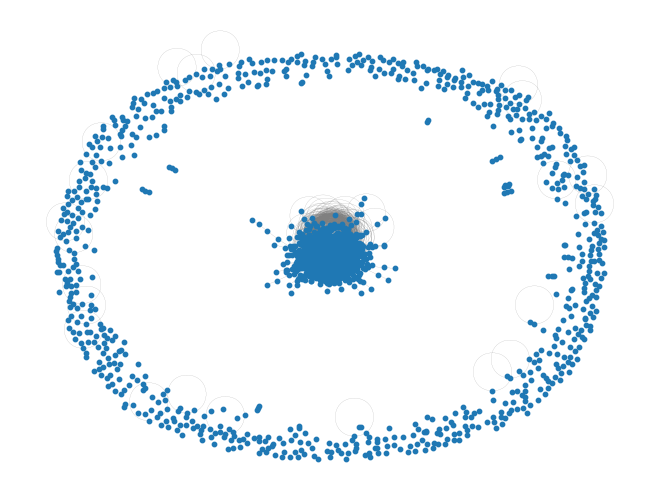

In [10]:
pos = nx.spring_layout(G)
nx.draw(G, cmap = plt.get_cmap('rainbow'), pos=pos, node_size=10, with_labels=False, edge_color='grey', width=0.1)

n = G.number_of_nodes()
m = G.number_of_edges()
print("Número de nós : %d" % n)
print("Número de arestas : %d" % m)
print("Número de componentes conectados : %d" % nx.number_connected_components(G))

In [11]:
# Remove 20% das arestas
proportion_edges = 0.2
edge_subset = random.sample(sorted(G.edges()), int(proportion_edges * G.number_of_edges()))

# Cria uma cópia do grafo e remove arestas
G_train = G.copy()
G_train.remove_edges_from(edge_subset)

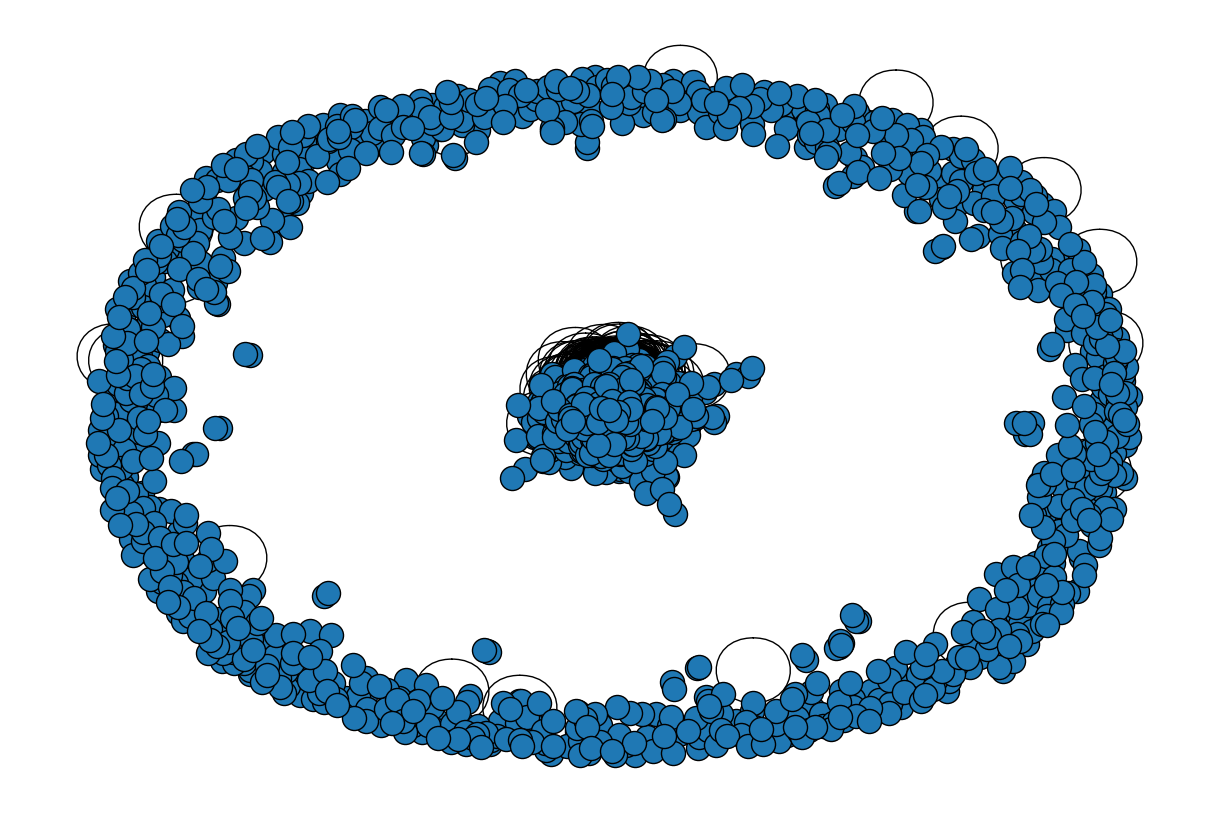

In [12]:
plt.figure(figsize=(12,8))
nx.draw(G_train)
plt.gca().collections[0].set_edgecolor("#000000") 

In [13]:
edge_subset_size = len(list(edge_subset))
print("Número de arestas removidas : %d" % edge_subset_size)
print("Número de arestas restantes : %d" % (m - edge_subset_size))

Número de arestas removidas : 3798
Número de arestas restantes : 15193


### Jaccard Coeefficient

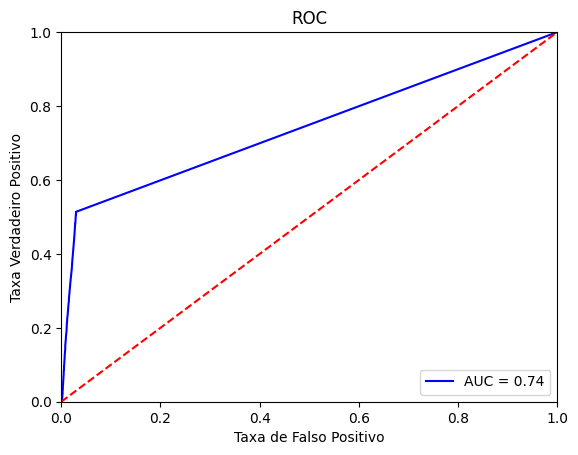

In [16]:
# Fazendo previsões com o jaccard
pred_jaccard = nx.jaccard_coefficient(G_train)

pred_jaccard_list = list(pred_jaccard)

print("Número de previsões : %d" % len(pred_jaccard_list))

jaccard_df = pd.DataFrame(pred_jaccard_list, columns=['node1', 'node2', 'score'])
jaccard_df = jaccard_df.sort_values(by='score', ascending=False)

jaccard_df['label'] = jaccard_df.apply(lambda row: (row['node1'], row['node2']) in edge_subset, axis=1)


# Computa o AUC score da curva ROC
fpr_jaccard, tpr_jaccard, _ = metrics.roc_curve(jaccard_df['label'], jaccard_df['score'])
auc_jaccard = roc_auc_score(jaccard_df['label'], jaccard_df['score'])


#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_jaccard, tpr_jaccard, 'b', label = 'AUC = %0.2f' % auc_jaccard)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

### Preferential Attachment 

Número de previsões : 10448156
0.8896824871540382


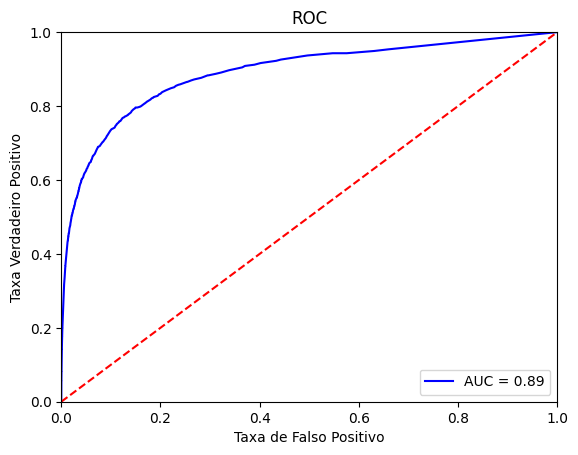

In [40]:
pred_prefAtch = nx.preferential_attachment(G_train)

pred_prefAtch_list = list(pred_prefAtch)

print("Número de previsões : %d" % len(pred_prefAtch_list))

prefAtch_df = pd.DataFrame(pred_prefAtch_list, columns=['node1', 'node2', 'score'])
prefAtch_df = prefAtch_df.sort_values(by='score', ascending=False)

prefAtch_df['label'] = prefAtch_df.apply(lambda row: (row['node1'], row['node2']) in edge_subset, axis=1)

# Computa o AUC score da curva ROC
fpr_prefAtch, tpr_prefAtch, _ = metrics.roc_curve(prefAtch_df['label'], prefAtch_df['score'])
auc_prefAtch = roc_auc_score(prefAtch_df['label'], prefAtch_df['score'])
print(auc_prefAtch)


#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_prefAtch, tpr_prefAtch, 'b', label = 'AUC = %0.2f' % auc_prefAtch)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

In [41]:
prefAtch_df.head(100)

,node1,node2,score,label
9088102,u4sTiCzVeIHZY8OlaL346Q,gldPX9ANF5Nic0N7igu2og,34592,False
7535135,woXlprCuowrLJswWere3TQ,gldPX9ANF5Nic0N7igu2og,30360,True
7533227,woXlprCuowrLJswWere3TQ,dLc1d1zwd1Teu2QED5TmlA,28710,False
5405373,Voeq7aGDmCGMjE_SQiHwRA,dLc1d1zwd1Teu2QED5TmlA,26796,False
4632458,BcLFIr4wtd3GQ3fnz15yDQ,u4sTiCzVeIHZY8OlaL346Q,25944,True
...,...,...,...,...
5745533,d2ZQRjuizstCTnicysmpMQ,u4sTiCzVeIHZY8OlaL346Q,12032,False
4497410,OPcGFLP_mRt9yvgP3ALXOQ,Voeq7aGDmCGMjE_SQiHwRA,12012,False
9780371,Q4WmBfRD6rcTSXVZqjKC5Q,gldPX9ANF5Nic0N7igu2og,11960,False
7911876,SmkYLXEYhzwUZdS6TAevHg,MKYcOZSpMwJK7uwacK13EA,11844,False


### Resource Allocation

In [42]:
pred_ra = nx.resource_allocation_index(G_train)

pred_ra_list = list(pred_ra)

print("Número de previsões : %d" % len(pred_ra_list))

ra_df = pd.DataFrame(pred_ra_list, columns=['node1', 'node2', 'score'])
ra_df = ra_df.sort_values(by='score', ascending=False)

ra_df['label'] = ra_df.apply(lambda row: (row['node1'], row['node2']) in edge_subset, axis=1)

# Computa o AUC score da curva ROC
fpr_ra, tpr_ra, _ = metrics.roc_curve(ra_df['label'], ra_df['score'])
auc_ra = roc_auc_score(ra_df['label'], ra_df['score'])
print(auc_ra)


#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_ra, tpr_ra, 'b', label = 'AUC = %0.2f' % auc_ra)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

Número de previsões : 10448156


In [27]:
label_ra

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [28]:
score_ra

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


### Common Neighbor Centrality

0.8674744419029685


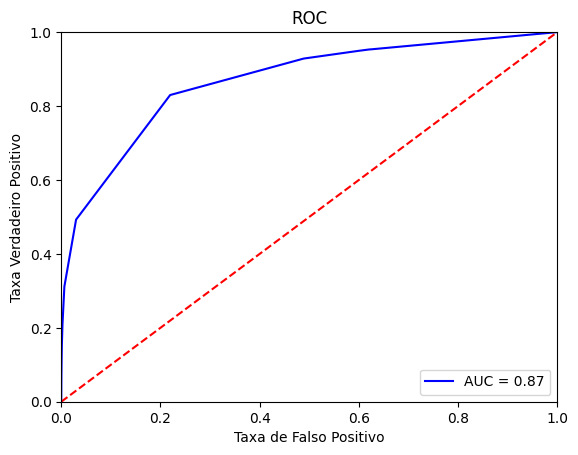

In [15]:
pred_CNC = nx.common_neighbor_centrality(G_train)
pred_CNC_list = list(pred_CNC)

print("Número de previsões : %d" % len(pred_CNC_list))

CNC_df = pd.DataFrame(pred_CNC_list, columns=['node1', 'node2', 'score'])
CNC_df = CNC_df.sort_values(by='score', ascending=False)

CNC_df['label'] = CNC_df.apply(lambda row: (row['node1'], row['node2']) in edge_subset, axis=1)

# Computa o AUC score da curva ROC
fpr_CNC, tpr_CNC, _ = metrics.roc_curve(CNC_df['label'], CNC_df['score'])
auc_CNC = roc_auc_score(CNC_df['label'], CNC_df['score'])
print(auc_CNC)

#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_CNC, tpr_CNC, 'b', label = 'AUC = %0.2f' % auc_CNC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

In [29]:
label_CNC

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [30]:
score_CNC

[182.99999999999997,
 152.49999999999997,
 182.99999999999997,
 0.0,
 228.74999999999994,
 0.0,
 130.7142857142857,
 228.74999999999994,
 182.99999999999997,
 182.99999999999997,
 228.74999999999994,
 182.99999999999997,
 182.99999999999997,
 228.74999999999994,
 304.99999999999994,
 0.0,
 0.0,
 228.74999999999994,
 228.74999999999994,
 182.99999999999997,
 182.99999999999997,
 182.99999999999997,
 228.74999999999994,
 228.74999999999994,
 182.99999999999997,
 228.74999999999994,
 182.99999999999997,
 182.99999999999997,
 228.74999999999994,
 0.0,
 228.74999999999994,
 228.74999999999994,
 228.74999999999994,
 152.49999999999997,
 182.99999999999997,
 228.74999999999994,
 228.74999999999994,
 228.74999999999994,
 228.74999999999994,
 228.74999999999994,
 0.0,
 228.74999999999994,
 228.74999999999994,
 0.0,
 228.74999999999994,
 182.99999999999997,
 0.0,
 182.99999999999997,
 182.99999999999997,
 182.99999999999997,
 0.0,
 0.0,
 228.74999999999994,
 228.74999999999994,
 0.0,
 182.999999

### Adamic Adar

0.7348797105184496


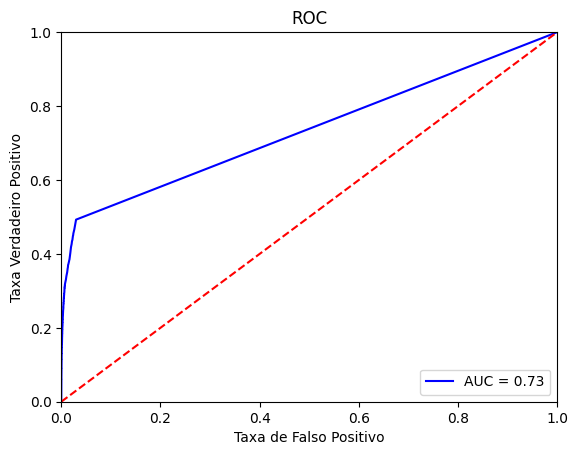

In [16]:
pred_adamic = list(nx.adamic_adar_index(G_train))

score_adamic = [s for (u,v,s) in pred_adamic]

label_adamic = [(u,v) in edge_subset for (u,v,s) in pred_adamic]

fpr_adamic, tpr_adamic, _ = metrics.roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)
print(auc_adamic)


#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_adamic, tpr_adamic, 'b', label = 'AUC = %0.2f' % auc_adamic)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

### Comparação entre os modelos

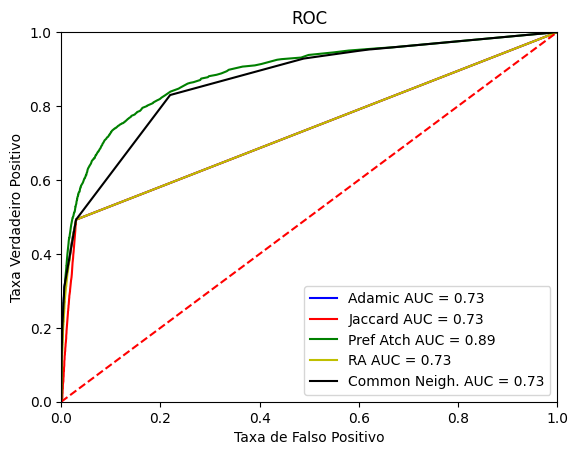

In [17]:
plt.title('ROC')
plt.plot(fpr_adamic, tpr_adamic, 'b', label = 'Adamic AUC = %0.2f' % auc_adamic)
plt.plot(fpr_jaccard, tpr_jaccard, 'r', label = 'Jaccard AUC = %0.2f' % auc_jaccard)
plt.plot(fpr_prefAtch, tpr_prefAtch, 'g', label = 'Pref Atch AUC = %0.2f' % auc_prefAtch)
plt.plot(fpr_ra, tpr_ra, 'y', label = 'RA AUC = %0.2f' % auc_ra)
plt.plot(fpr_CNC, tpr_CNC, 'k', label = 'Common Neigh. AUC = %0.2f' % auc_ra)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

In [9]:

A = nx.adjacency_matrix(G)
A.shape



C:\Users\rodri\AppData\Local\Temp\ipykernel_15944\2297324554.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


(4575, 4575)

In [12]:
# para guardar todos os pares de nós não conectados 
listUnconnected = []

# Varre a matriz de adjacência procurando por pares desconectados
offset = 0
for i in tqdm(range(A.shape[0])):
    for j in range(offset,A.shape[1]):
        if i != j:
            if A[i,j] == 0:
                listUnconnected.append([i,j])

    offset +=1



100%|██████████| 4575/4575 [02:10<00:00, 35.19it/s] 


In [13]:
unlinked1 = [i[0] for i in listUnconnected]
unlinked2 = [i[1] for i in listUnconnected]

dfPairs = pd.DataFrame({'node1':unlinked1, 
                     'node2':unlinked2})

# cria a variável 'link', onde 0= sem link e 1 com link
dfPairs['link'] = 0
dfPairs

,node1,node2,link
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,0
4,0,5,0
...,...,...,...
10444436,4571,4573,0
10444437,4571,4574,0
10444438,4572,4573,0
10444439,4572,4574,0


In [20]:
df = pd.DataFrame(edge_subset, columns=['node1', 'node2'])
df['link'] = 1

dfPairs = pd.concat([df,dfPairs])

,node1,node2,link
0,IUywieKL-xOm3tFJEY8fOw,X88w0XrUSIKue9Vuwtqs_g,1
1,QqbZA4r5g1vCbOxOAKJgWg,VpsXhgaBA7-65Gt2zg8Nkg,1
2,azE1DNVQFBU8boVbaJhj7w,4iSVxQKK1G3V-LBffQxaKg,1
3,7z2x16M7IuG8KPfMsyVrKA,haQkLoAcdUBvLteoY6NnJA,1
4,Eg_M8eeu9SDEdbP7iUmVbQ,caGXS6ubNTlv91ZZyoirjQ,1
...,...,...,...
3793,iuOK9_SBaJ5y0xzu4Fy4IQ,aU3MBJ3Cq5yip6JTyJi7KQ,1
3794,4mYS-4UOjTKgsf0tX1_IkQ,HPX1pRtWInt_UVtfld-zsQ,1
3795,BY1_pf7FHUycHOwYEenDlQ,_vzNvnj8ob0hAk2QXEv3Mw,1
3796,qXGKYRwCR9SLgLl0g_9o5g,oeW0vIYd3rUnAPgmD4fEFg,1


In [21]:
dfPairs

,node1,node2,link
0,IUywieKL-xOm3tFJEY8fOw,X88w0XrUSIKue9Vuwtqs_g,1
1,QqbZA4r5g1vCbOxOAKJgWg,VpsXhgaBA7-65Gt2zg8Nkg,1
2,azE1DNVQFBU8boVbaJhj7w,4iSVxQKK1G3V-LBffQxaKg,1
3,7z2x16M7IuG8KPfMsyVrKA,haQkLoAcdUBvLteoY6NnJA,1
4,Eg_M8eeu9SDEdbP7iUmVbQ,caGXS6ubNTlv91ZZyoirjQ,1
...,...,...,...
10444436,4571,4573,0
10444437,4571,4574,0
10444438,4572,4573,0
10444439,4572,4574,0


In [22]:
from node2vec import Node2Vec

# Gera caminhos 
node2vec = Node2Vec(G_train, dimensions=100, walk_length=16, num_walks=50)

# treina o modelo node2vec
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/4575 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


In [23]:
#representa as arestas pela soma dos embeddings dos nós
featuresPares = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(dfPairs['node1'], dfPairs['node2'])]

KeyError: "Key '0' not present"